In [ ]:
#upload file
from google.colab import files
uploaded = files.upload()

Saving cgm_light.db to cgm_light.db


Training random forest with grid search...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Root Mean Squared Error after tuning: 15.100962705727177
Number of series_ids in test set: 5
Visualizing predictions for series_id: 1 with 3302 data points
Series-specific Mean Absolute Error: 19.64
Series-specific Root Mean Square Error: 28.78


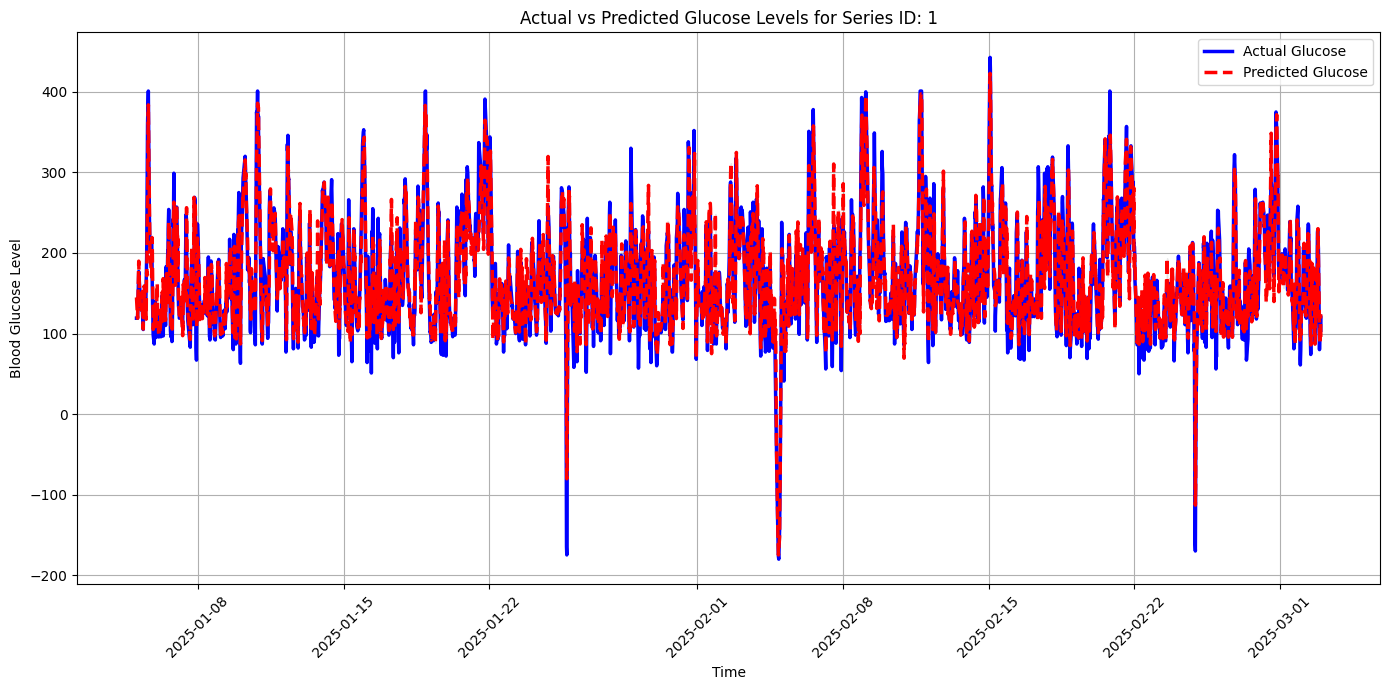

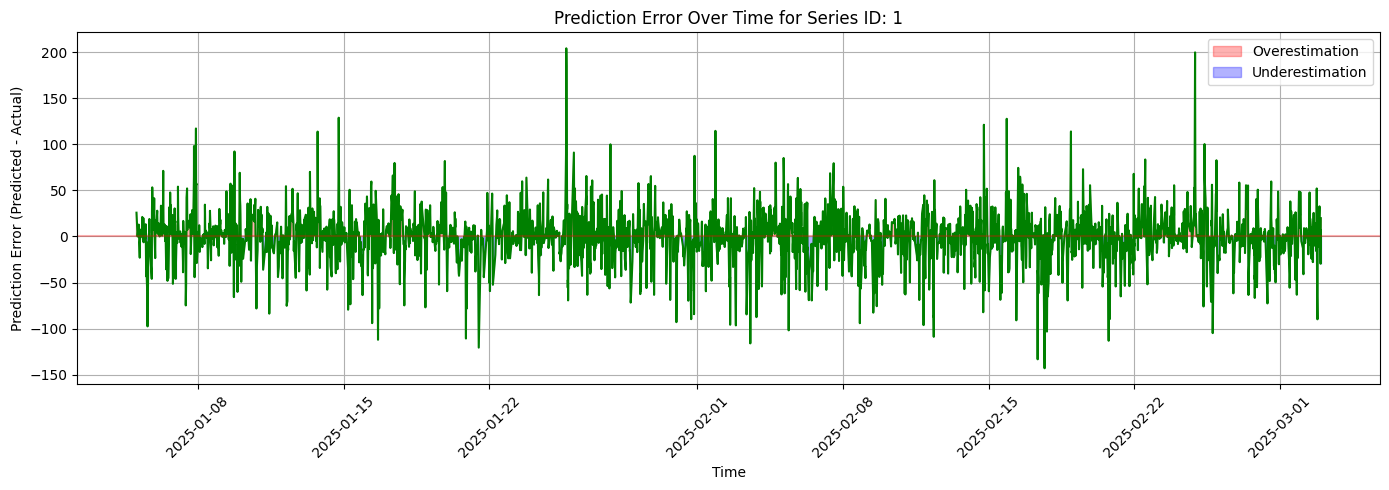

In [ ]:
#visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import math
import sqlite3

# Connect to the database and load data
conn = sqlite3.connect('cgm_light.db')
df = pd.read_sql("SELECT * FROM cgm_data", conn)
conn.close()

# Data preprocessing
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values(by=['series_id', 'datetime'], inplace=True)

# Remove duplicates
df = df.groupby(['series_id', 'datetime'], as_index=False).agg({'blood_glucose': 'mean'})

# Resample to 5-minute intervals and interpolate
resampled = []
for sid, group in df.groupby('series_id'):
    group = group.set_index('datetime').sort_index()

    # Resample to 5-minute intervals
    group_resampled = group.resample('5min').mean()

    # Interpolate missing values
    if group_resampled['blood_glucose'].notna().sum() >= 3:
        try:
            group_resampled['blood_glucose'] = group_resampled['blood_glucose'].interpolate(method='polynomial', order=2)
        except:
            group_resampled['blood_glucose'] = group_resampled['blood_glucose'].interpolate(method='linear')
    else:
        group_resampled['blood_glucose'] = group_resampled['blood_glucose'].interpolate(method='linear')

    # Fill remaining edge NaNs
    group_resampled['blood_glucose'] = group_resampled['blood_glucose'].bfill().ffill()

    # Add series_id back
    group_resampled['series_id'] = sid
    resampled.append(group_resampled)

df_resampled = pd.concat(resampled).reset_index()

# Feature engineering
df_resampled['hour'] = df_resampled['datetime'].dt.hour
df_resampled['dayofweek'] = df_resampled['datetime'].dt.dayofweek
df_resampled['glucose_lag_1'] = df_resampled.groupby('series_id')['blood_glucose'].shift(1)
df_resampled['glucose_lag_6'] = df_resampled.groupby('series_id')['blood_glucose'].shift(6)
df_resampled['glucose_target'] = df_resampled.groupby('series_id')['blood_glucose'].shift(-6)  # 30 minutes in the future
df_resampled = df_resampled.dropna()

# --- Define Features and Target ---
features = ['hour', 'dayofweek', 'glucose_lag_1', 'glucose_lag_6', 'series_id']
target = 'glucose_target'

# Create a copy of the dataframe to work with
df_ml = df_resampled.copy()

# Create features (X) and target (y)
X = df_ml[features]
y = df_ml[target]

# One-hot encode 'series_id'
X = pd.get_dummies(X, columns=['series_id'], drop_first=True)

# --- Train-Test Split ---
# Save the indices for later reference
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_indices = X_train.index
test_indices = X_test.index

# --- Hyperparameter Tuning with GridSearchCV ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

print("Training random forest with grid search...")
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# --- Evaluate Best Model ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Root Mean Squared Error after tuning: {rmse}")

# Create a new dataframe for test data with predictions
test_data = df_ml.loc[test_indices].copy()
test_data['predicted_glucose'] = y_pred

# Get list of unique series_ids in the test set
unique_series_ids = test_data['series_id'].unique()
print(f"Number of series_ids in test set: {len(unique_series_ids)}")

# Select the first series_id that has enough data points for visualization
min_data_points = 20
selected_series_id = None

for sid in unique_series_ids:
    series_data = test_data[test_data['series_id'] == sid]
    if len(series_data) >= min_data_points:
        selected_series_id = sid
        break

if selected_series_id is None:
    # Select the series with the most data points
    series_counts = test_data['series_id'].value_counts()
    if len(series_counts) > 0:
        selected_series_id = series_counts.index[0]
        print(f"Using series_id {selected_series_id} with {series_counts[0]} data points instead.")
    else:
        print("No valid series found in test data.")
        exit()

# Filter test data for the selected series
series_test_data = test_data[test_data['series_id'] == selected_series_id].copy()
print(f"Visualizing predictions for series_id: {selected_series_id} with {len(series_test_data)} data points")

# Sort by datetime to ensure proper visualization
series_test_data = series_test_data.sort_values('datetime')

# Visualize the results
plt.figure(figsize=(14, 7))

# Plot actual vs predicted glucose values
plt.plot(series_test_data['datetime'], series_test_data['glucose_target'], 'b-', linewidth=2.5, label='Actual Glucose')
plt.plot(series_test_data['datetime'], series_test_data['predicted_glucose'], 'r--', linewidth=2.5, label='Predicted Glucose')

# Add shading between the lines to highlight differences
plt.fill_between(series_test_data['datetime'],
                 series_test_data['glucose_target'],
                 series_test_data['predicted_glucose'],
                 color='lightgray', alpha=0.5)

# Add a title and labels
plt.title(f'Actual vs Predicted Glucose Levels for Series ID: {selected_series_id}')
plt.xlabel('Time')
plt.ylabel('Blood Glucose Level')
plt.legend()
plt.grid(True)

# Format x-axis for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Calculate error metrics for this series
series_mae = np.mean(np.abs(series_test_data['predicted_glucose'] - series_test_data['glucose_target']))
series_rmse = np.sqrt(np.mean((series_test_data['predicted_glucose'] - series_test_data['glucose_target'])**2))

print(f"Series-specific Mean Absolute Error: {series_mae:.2f}")
print(f"Series-specific Root Mean Square Error: {series_rmse:.2f}")

plt.savefig('glucose_prediction_comparison.png')
plt.show()  # Display the first plot

# Create a second plot showing the error over time
plt.figure(figsize=(14, 5))
error = series_test_data['predicted_glucose'] - series_test_data['glucose_target']
plt.plot(series_test_data['datetime'], error, 'g-', linewidth=1.5)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.fill_between(series_test_data['datetime'], error, 0, where=(error > 0), color='red', alpha=0.3, label='Overestimation')
plt.fill_between(series_test_data['datetime'], error, 0, where=(error < 0), color='blue', alpha=0.3, label='Underestimation')

plt.title(f'Prediction Error Over Time for Series ID: {selected_series_id}')
plt.xlabel('Time')
plt.ylabel('Prediction Error (Predicted - Actual)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('glucose_prediction_error.png')
plt.show()


Visualizing predictions for series_id: 1 with 3302 data points


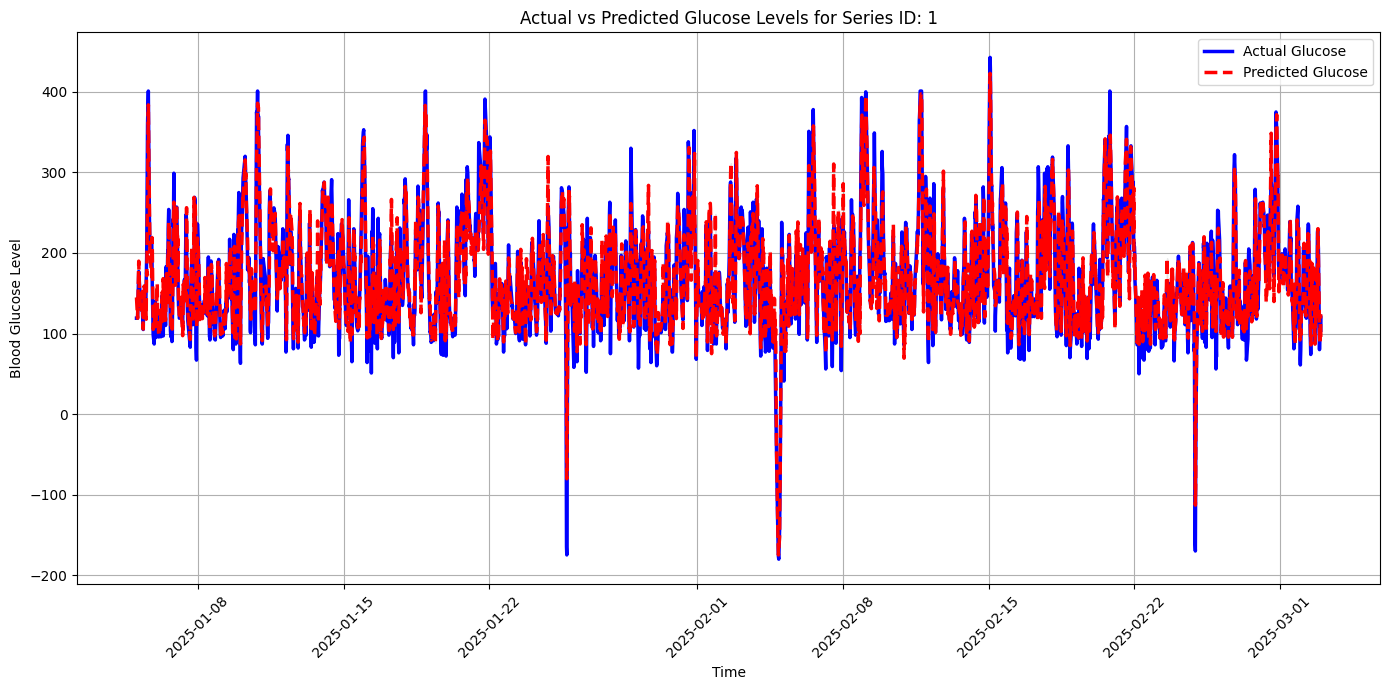

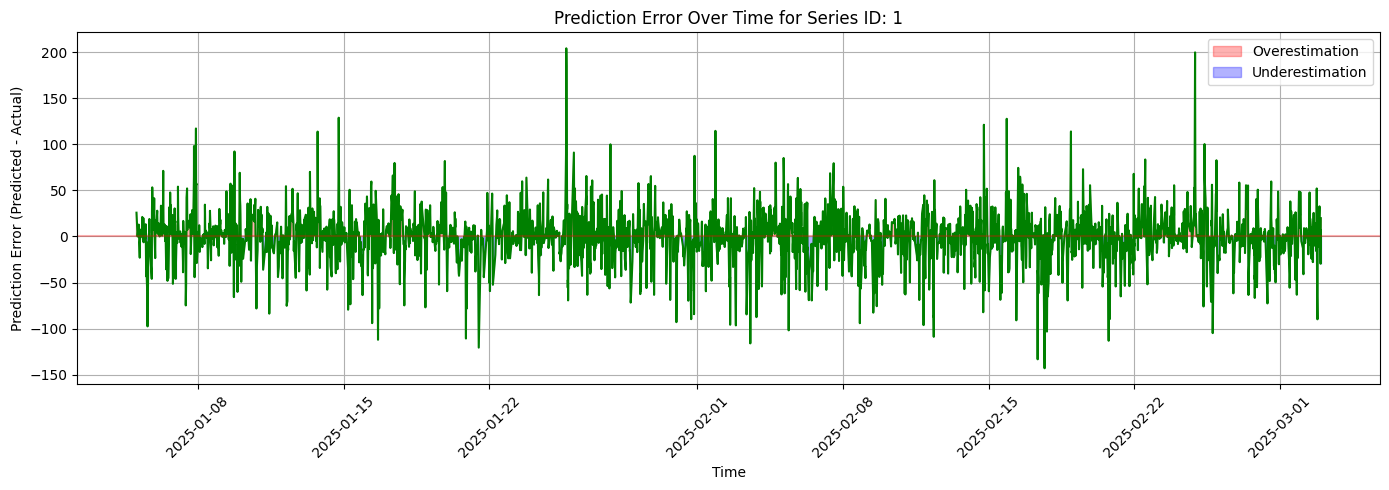

Series-specific MAE: 19.64, RMSE: 28.78

Visualizing predictions for series_id: 3 with 12363 data points


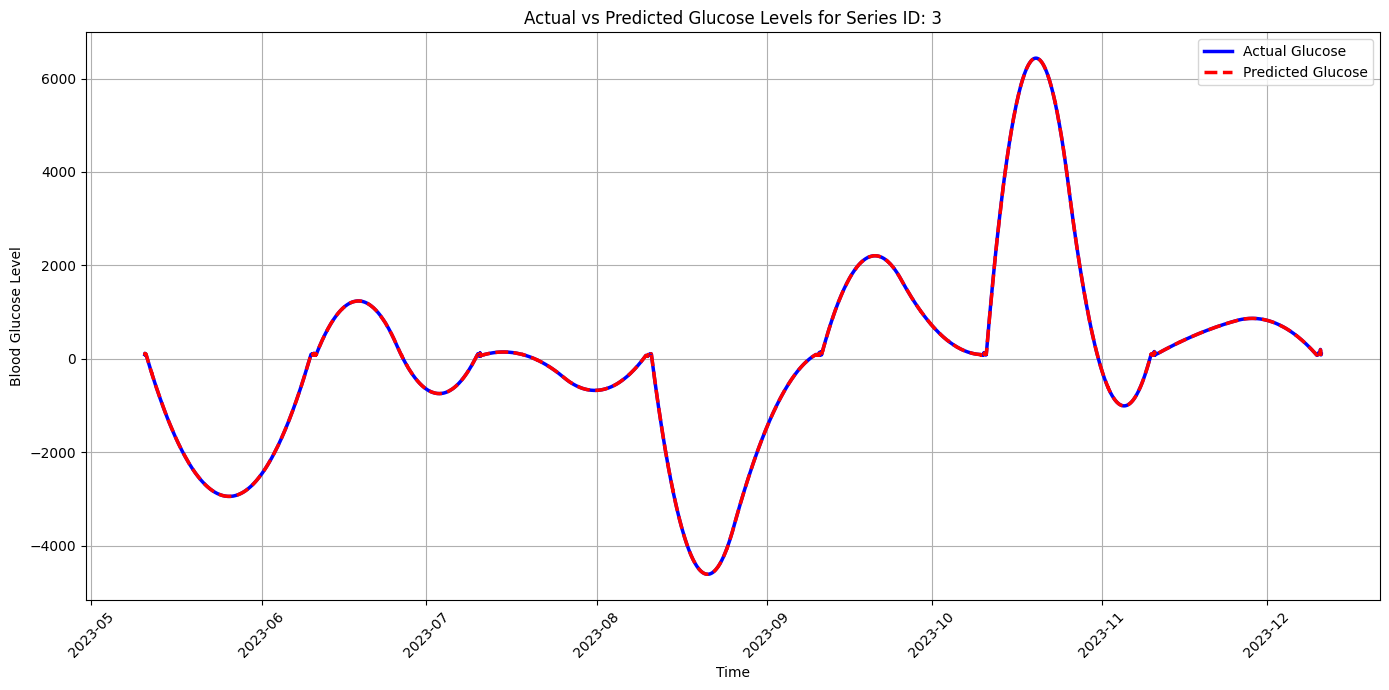

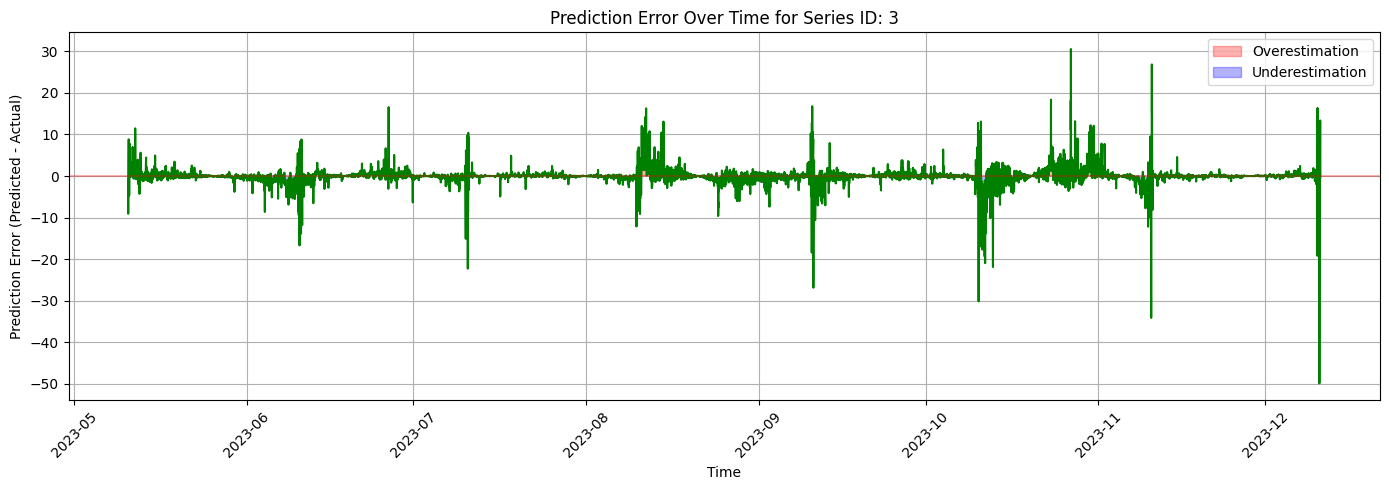

Series-specific MAE: 0.84, RMSE: 2.07

Visualizing predictions for series_id: 5 with 686 data points


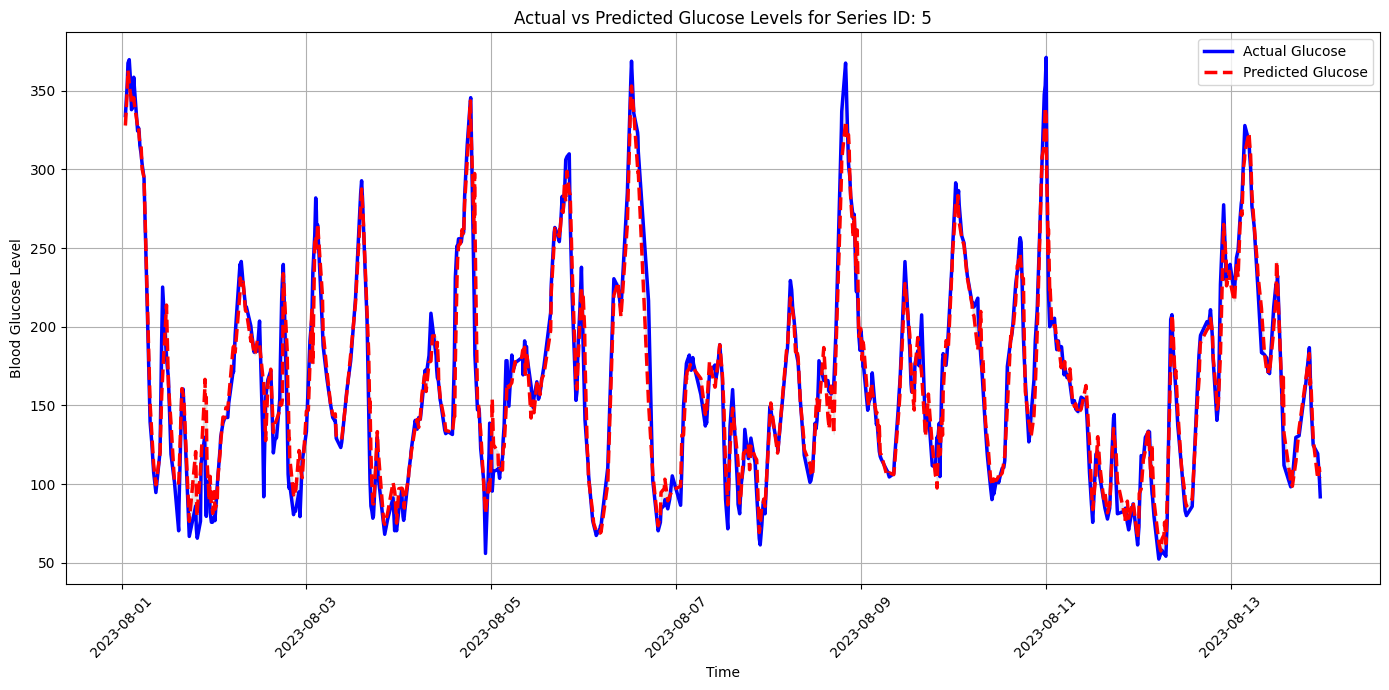

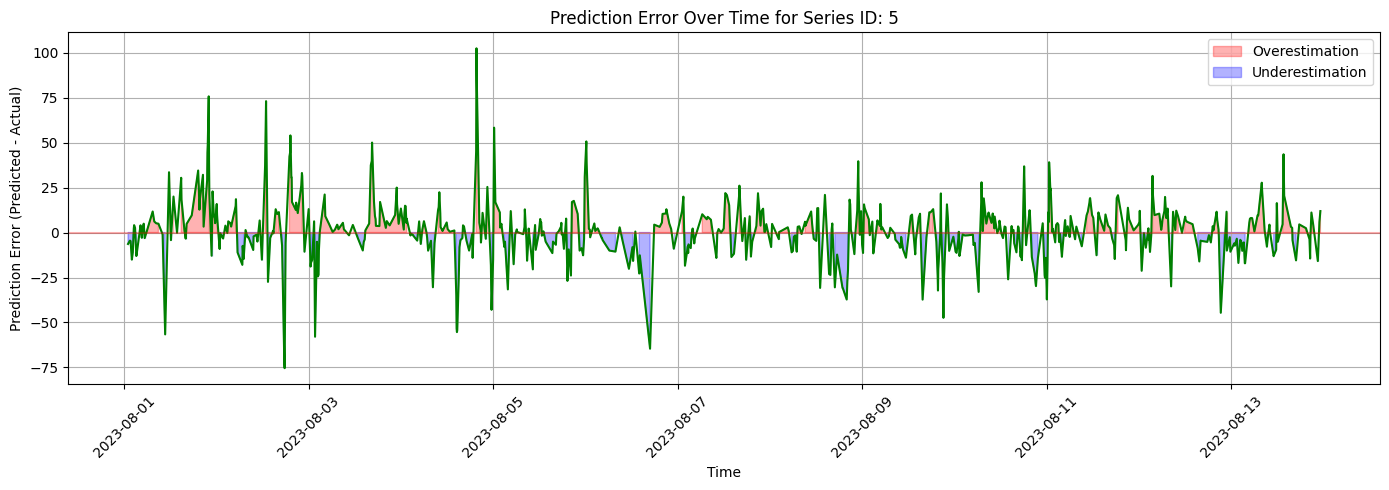

Series-specific MAE: 11.52, RMSE: 17.31

Visualizing predictions for series_id: 2 with 1804 data points


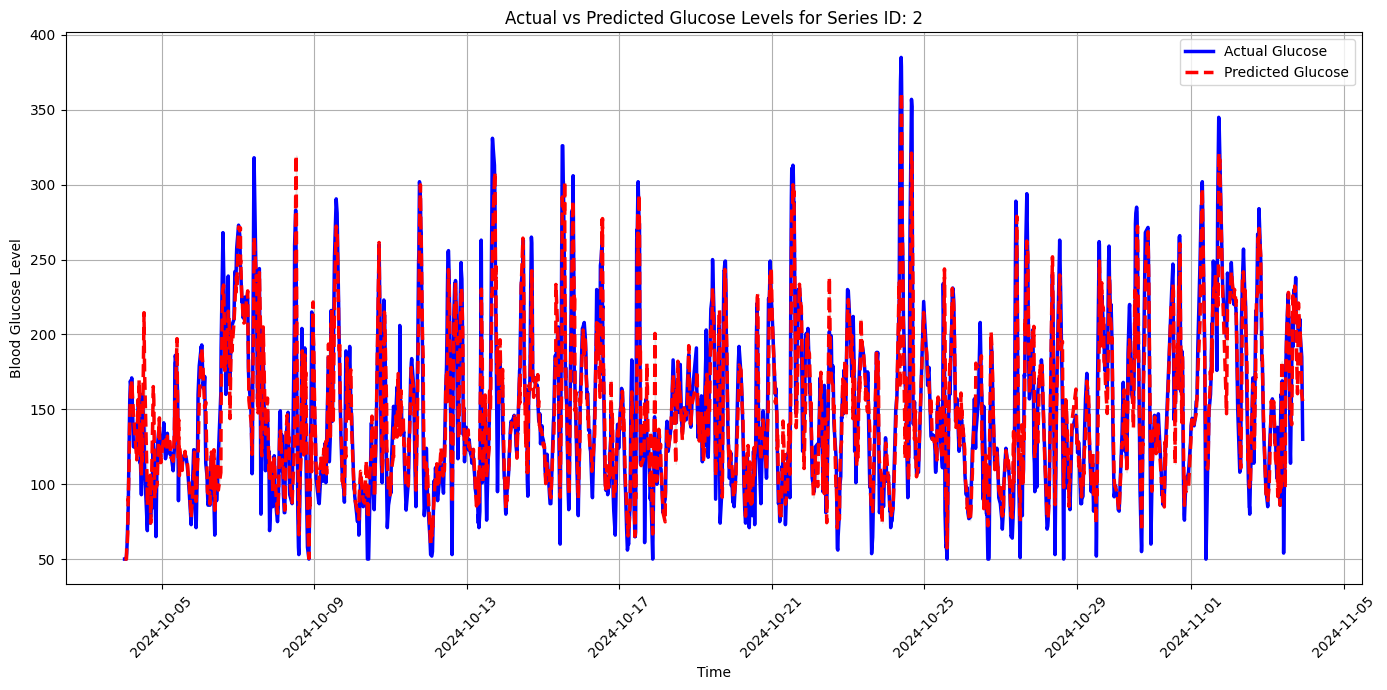

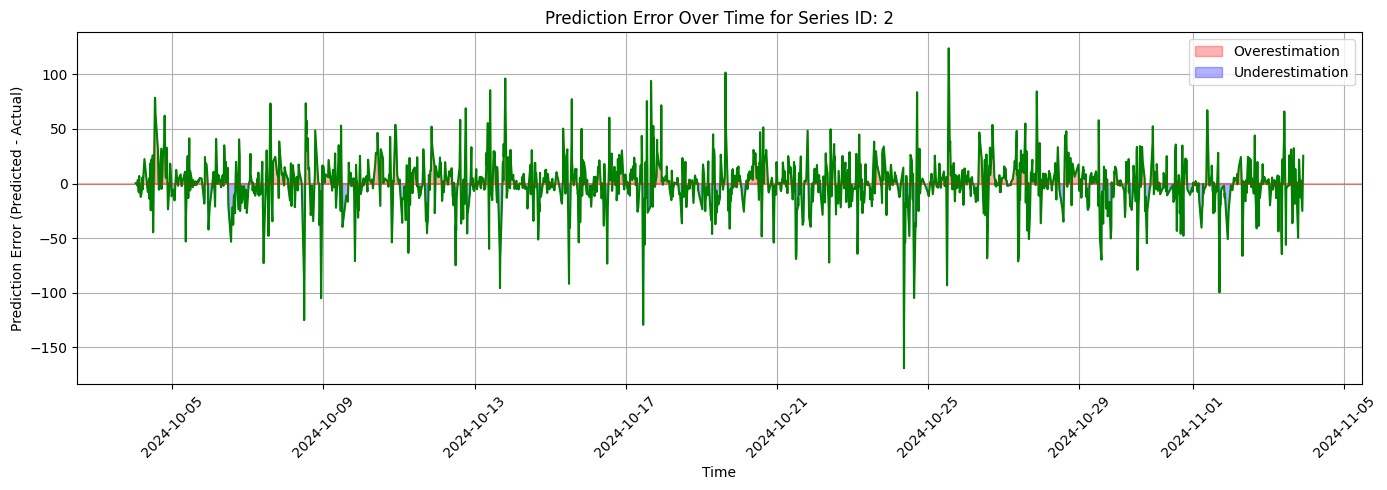

Series-specific MAE: 15.74, RMSE: 23.70

Visualizing predictions for series_id: 4 with 1778 data points


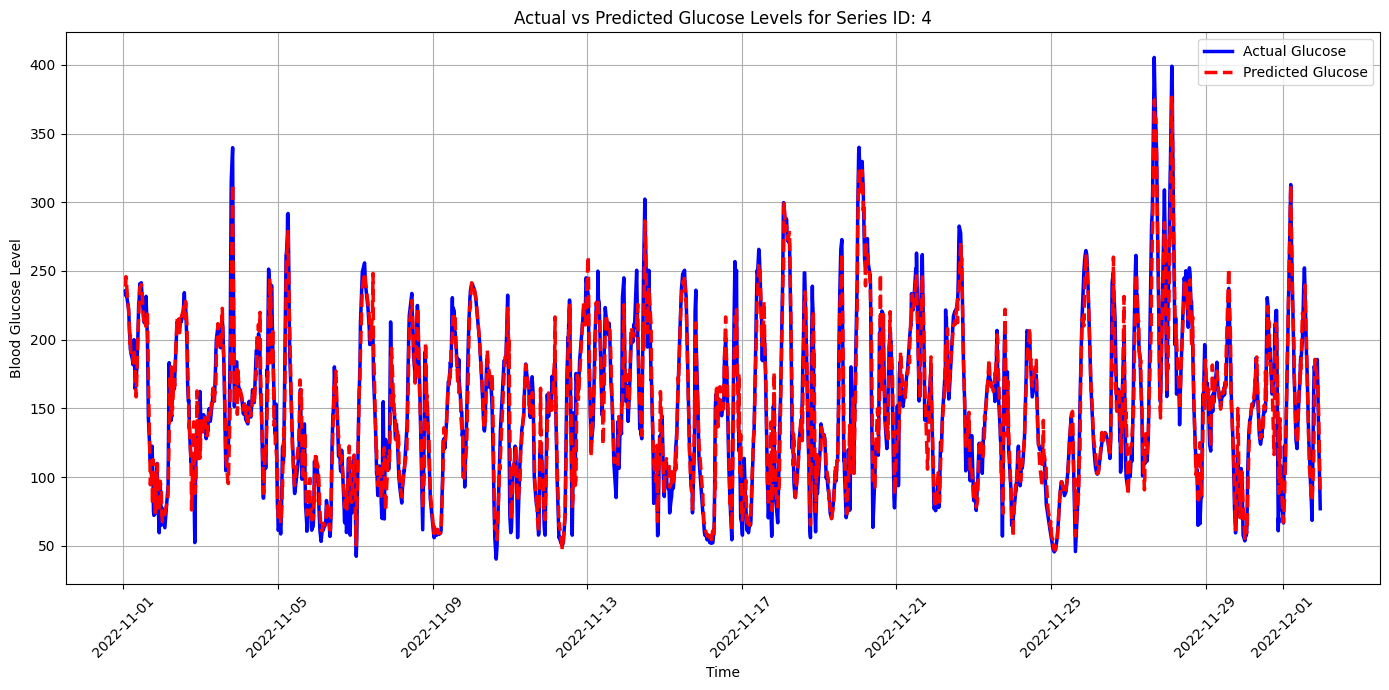

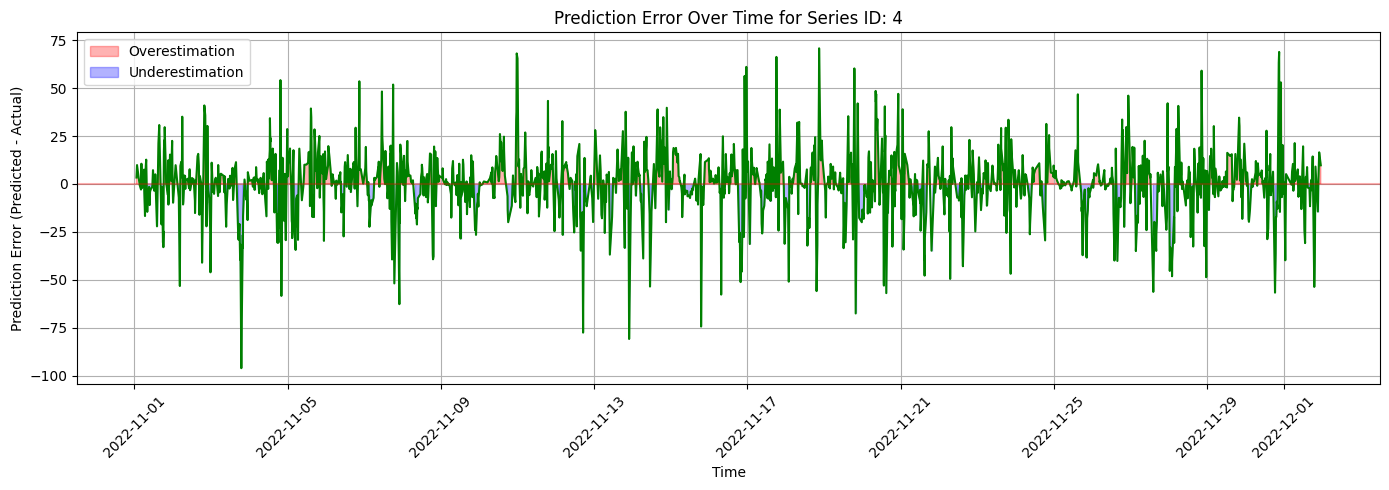

Series-specific MAE: 11.94, RMSE: 17.42

Summary of Series Metrics:
   series_id        MAE       RMSE
1          3   0.838051   2.074605
2          5  11.523102  17.310242
4          4  11.936782  17.419087
3          2  15.744462  23.698002
0          1  19.640632  28.775377


In [ ]:
# Loop through all unique series_ids in the test set
min_data_points = 20
series_metrics = []

for sid in unique_series_ids:
    series_test_data = test_data[test_data['series_id'] == sid].copy()
    if len(series_test_data) < min_data_points:
        continue

    print(f"\nVisualizing predictions for series_id: {sid} with {len(series_test_data)} data points")

    series_test_data = series_test_data.sort_values('datetime')

    # Plot actual vs predicted glucose
    plt.figure(figsize=(14, 7))
    plt.plot(series_test_data['datetime'], series_test_data['glucose_target'], 'b-', linewidth=2.5, label='Actual Glucose')
    plt.plot(series_test_data['datetime'], series_test_data['predicted_glucose'], 'r--', linewidth=2.5, label='Predicted Glucose')
    plt.fill_between(series_test_data['datetime'],
                     series_test_data['glucose_target'],
                     series_test_data['predicted_glucose'],
                     color='lightgray', alpha=0.5)
    plt.title(f'Actual vs Predicted Glucose Levels for Series ID: {sid}')
    plt.xlabel('Time')
    plt.ylabel('Blood Glucose Level')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'glucose_comparison_series_{sid}.png')
    plt.show()

    # Error over time
    plt.figure(figsize=(14, 5))
    error = series_test_data['predicted_glucose'] - series_test_data['glucose_target']
    plt.plot(series_test_data['datetime'], error, 'g-', linewidth=1.5)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.fill_between(series_test_data['datetime'], error, 0, where=(error > 0), color='red', alpha=0.3, label='Overestimation')
    plt.fill_between(series_test_data['datetime'], error, 0, where=(error < 0), color='blue', alpha=0.3, label='Underestimation')
    plt.title(f'Prediction Error Over Time for Series ID: {sid}')
    plt.xlabel('Time')
    plt.ylabel('Prediction Error (Predicted - Actual)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'glucose_error_series_{sid}.png')
    plt.show()

    # Calculate and store error metrics
    series_mae = np.mean(np.abs(error))
    series_rmse = np.sqrt(np.mean(error**2))
    print(f"Series-specific MAE: {series_mae:.2f}, RMSE: {series_rmse:.2f}")
    series_metrics.append({'series_id': sid, 'MAE': series_mae, 'RMSE': series_rmse})

# Optional: Show summary of metrics
metrics_df = pd.DataFrame(series_metrics)
print("\nSummary of Series Metrics:")
print(metrics_df.sort_values(by='RMSE'))


Training random forest with grid search...
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Root Mean Squared Error after tuning: 15.100962705727177
Number of series_ids in test set: 5
Processing series 1/5: 1


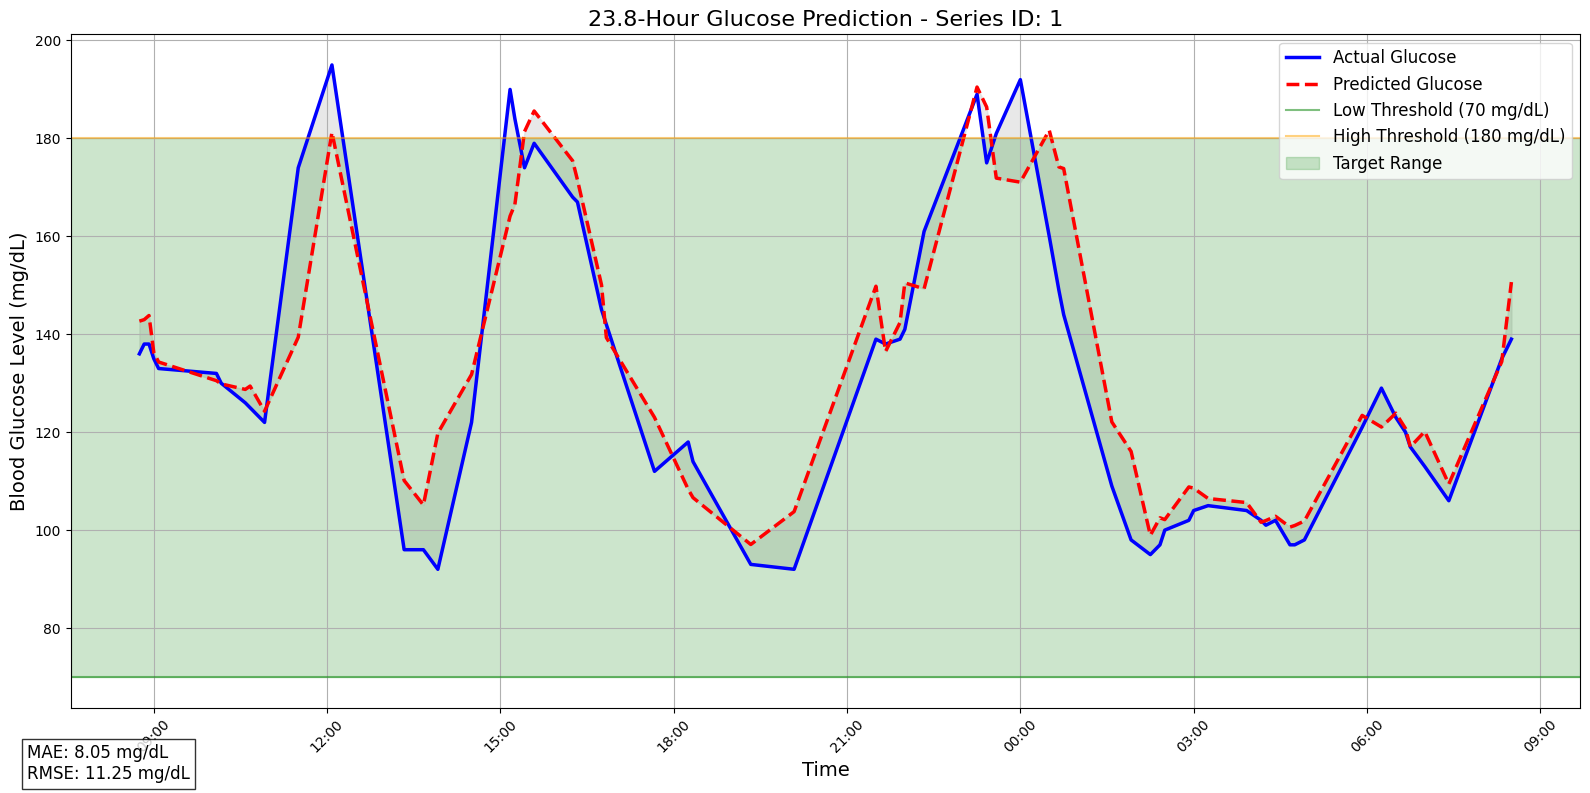

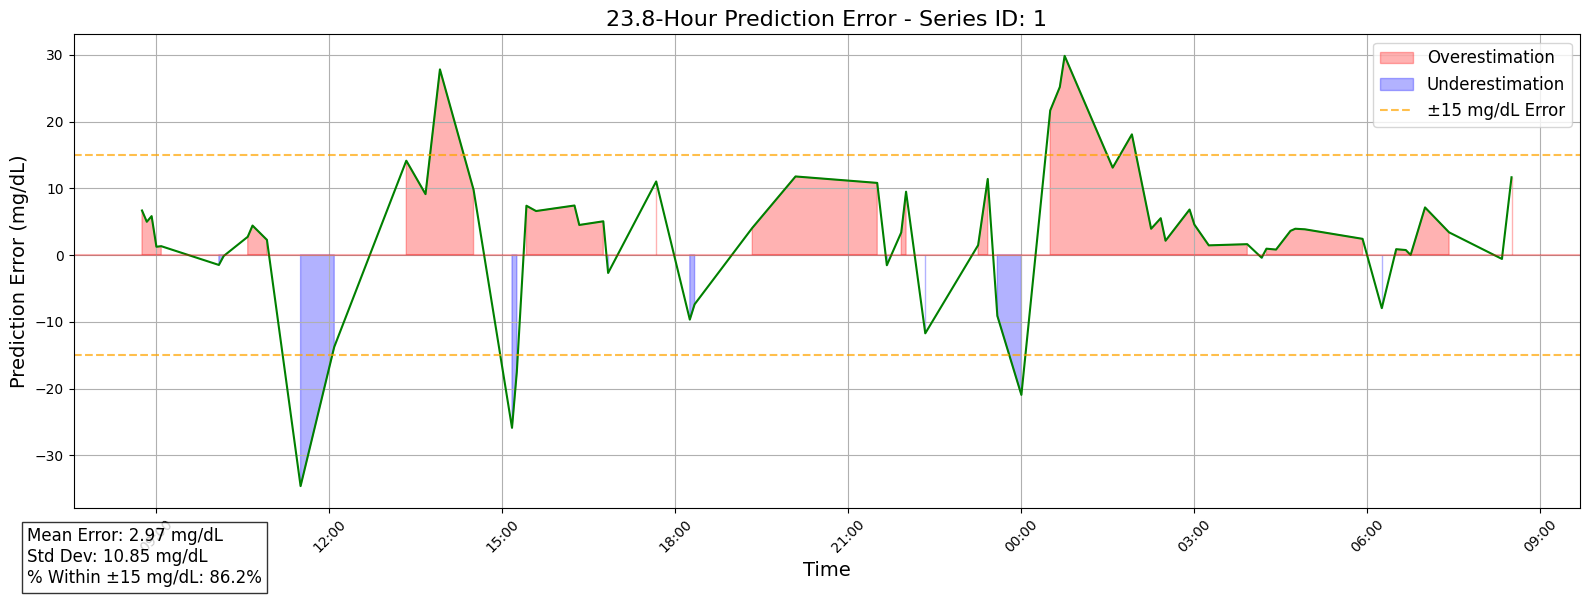

  Completed: 23.8 hours, 65 points, RMSE: 11.25
Processing series 2/5: 3


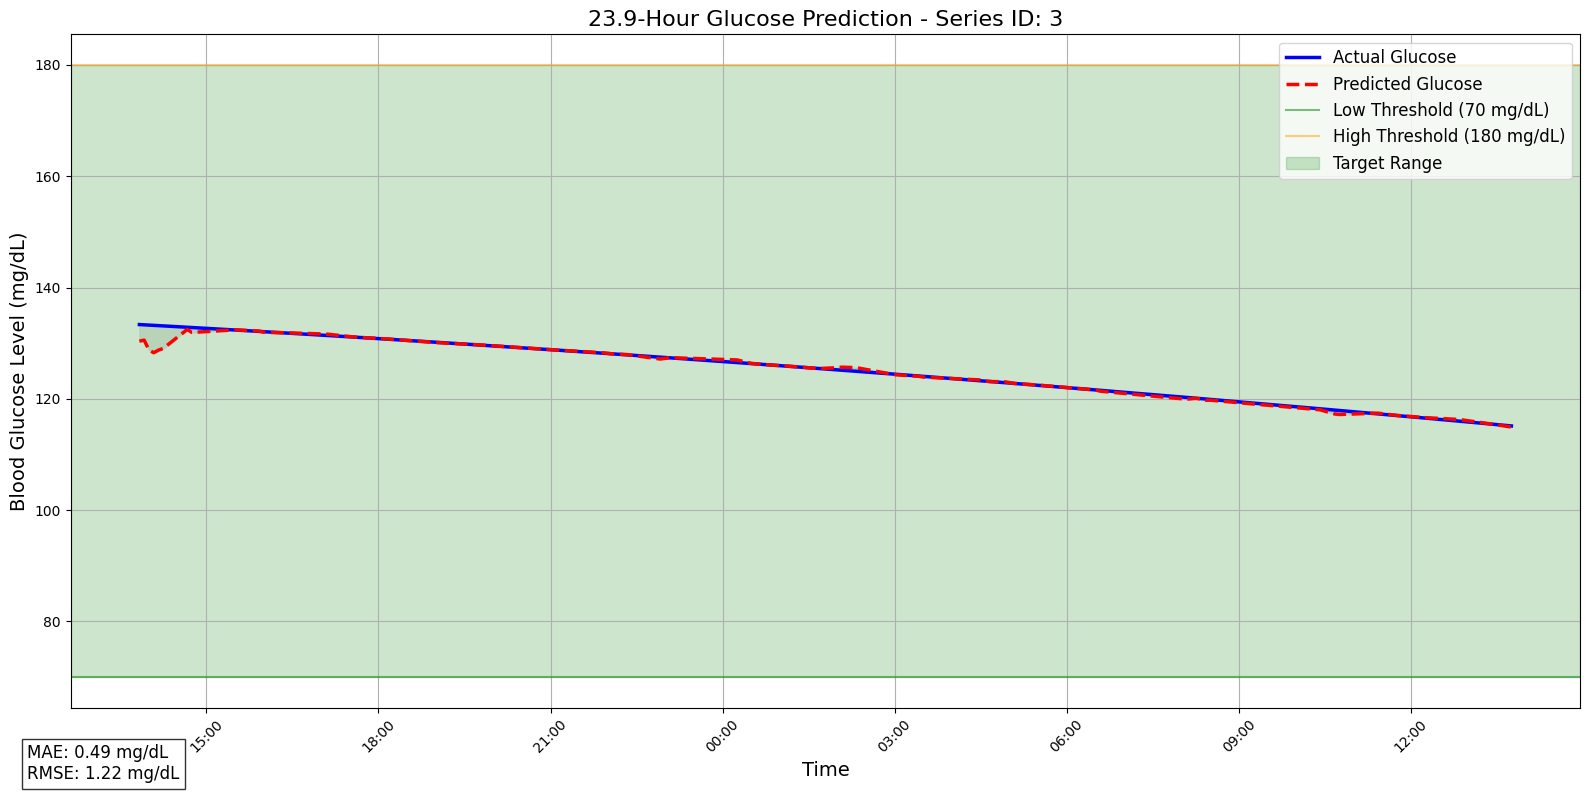

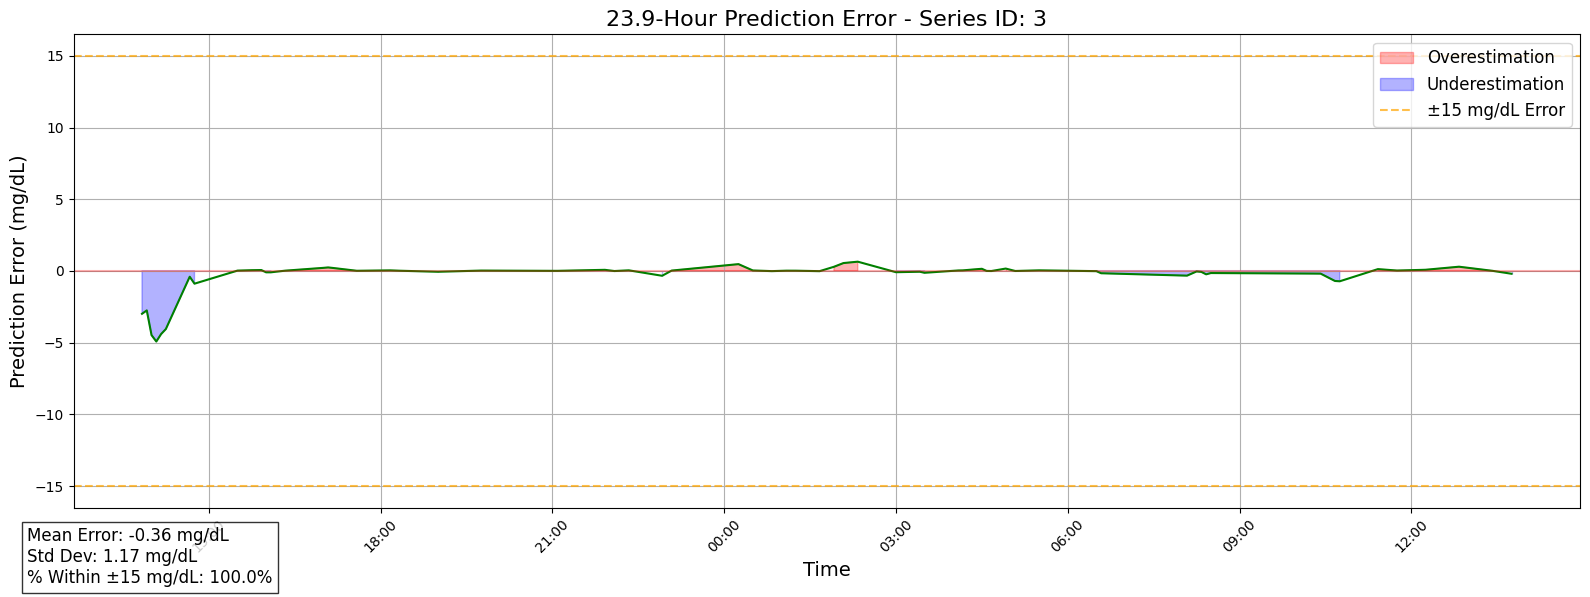

  Completed: 23.9 hours, 67 points, RMSE: 1.22
Processing series 3/5: 5


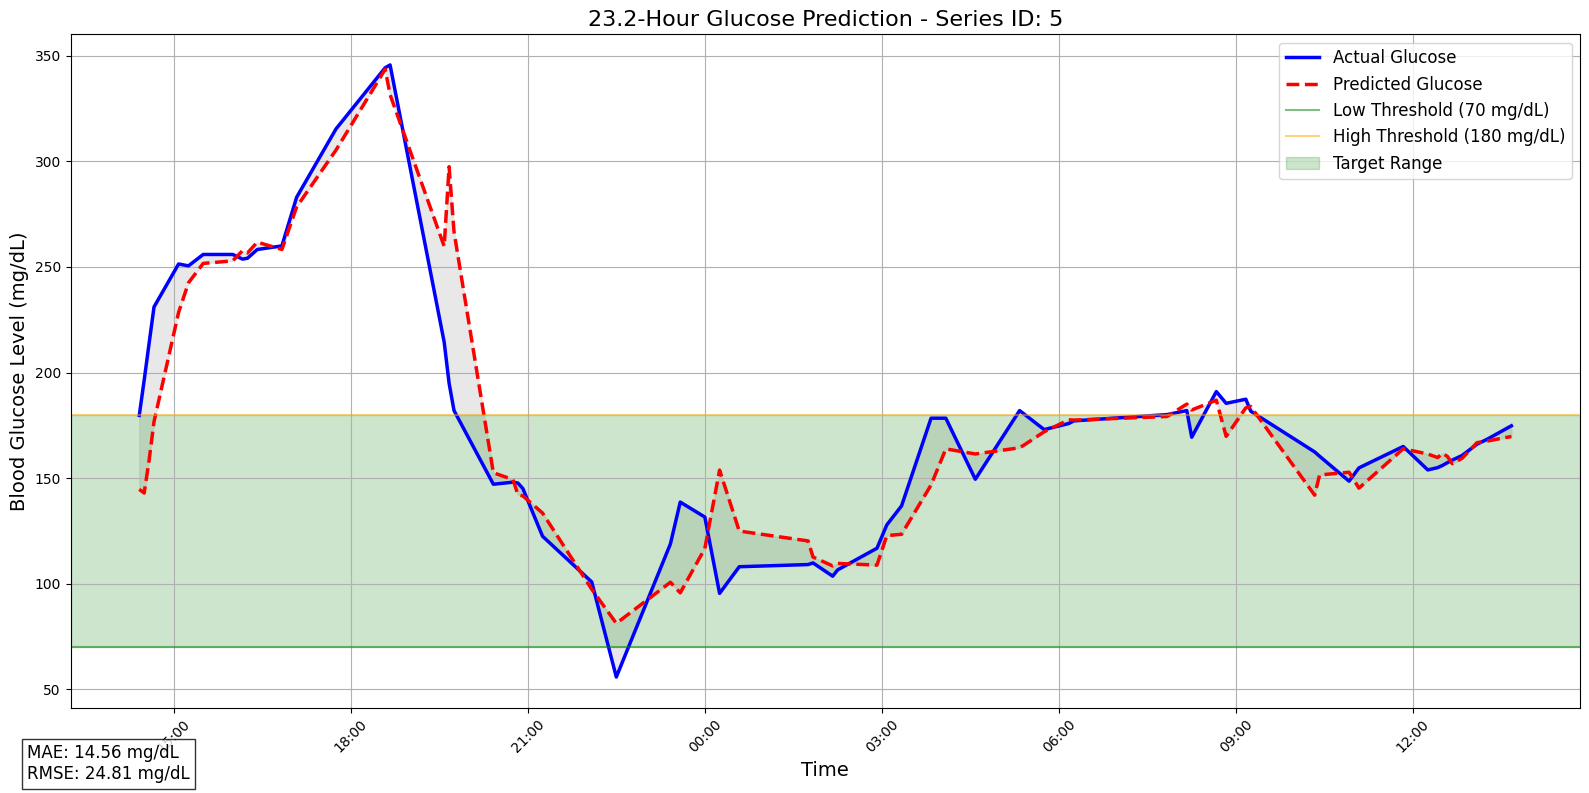

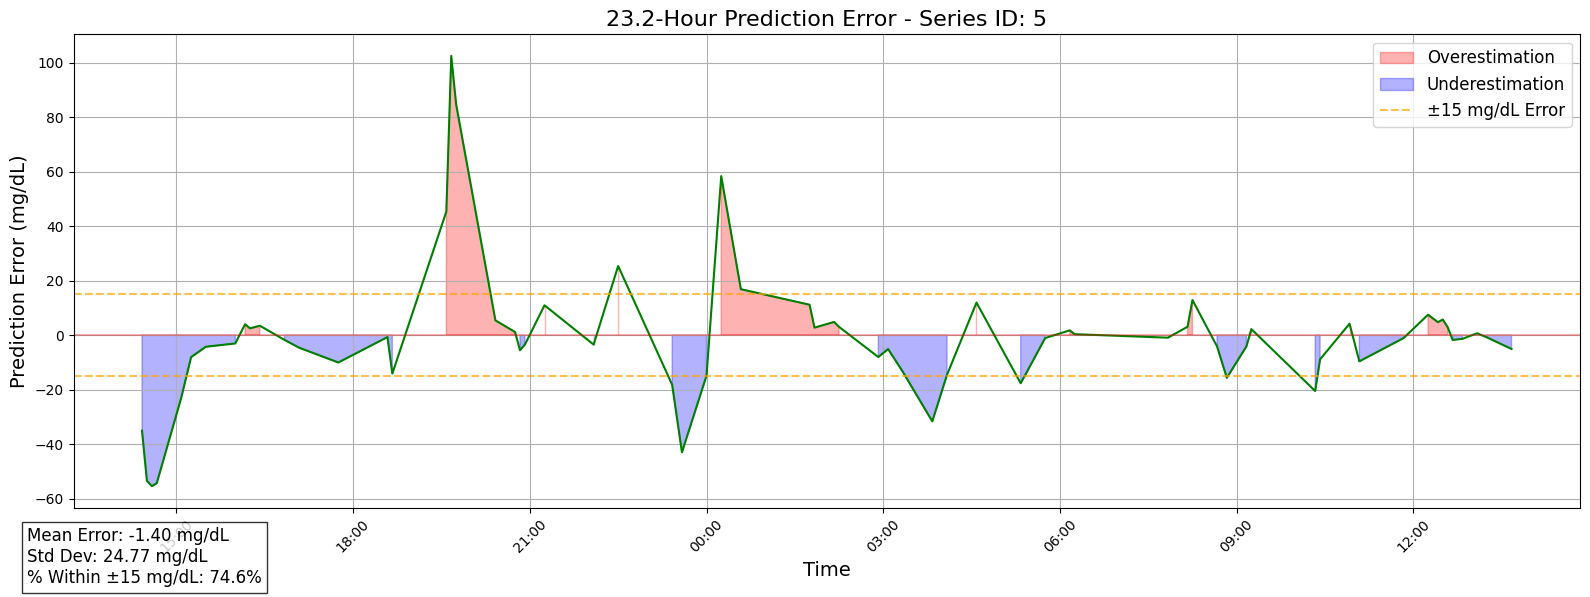

  Completed: 23.2 hours, 67 points, RMSE: 24.81
Processing series 4/5: 2


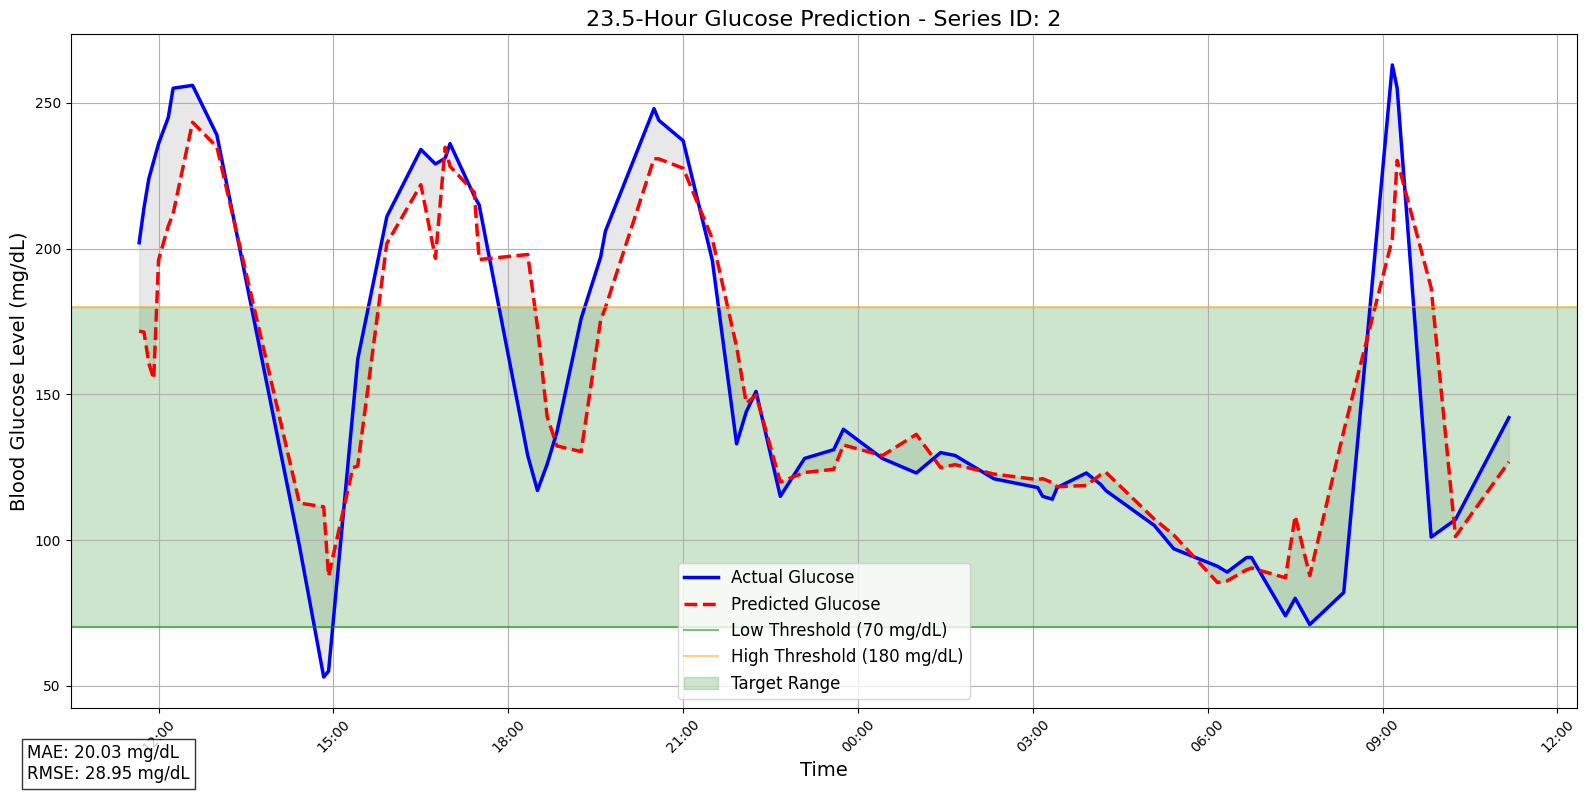

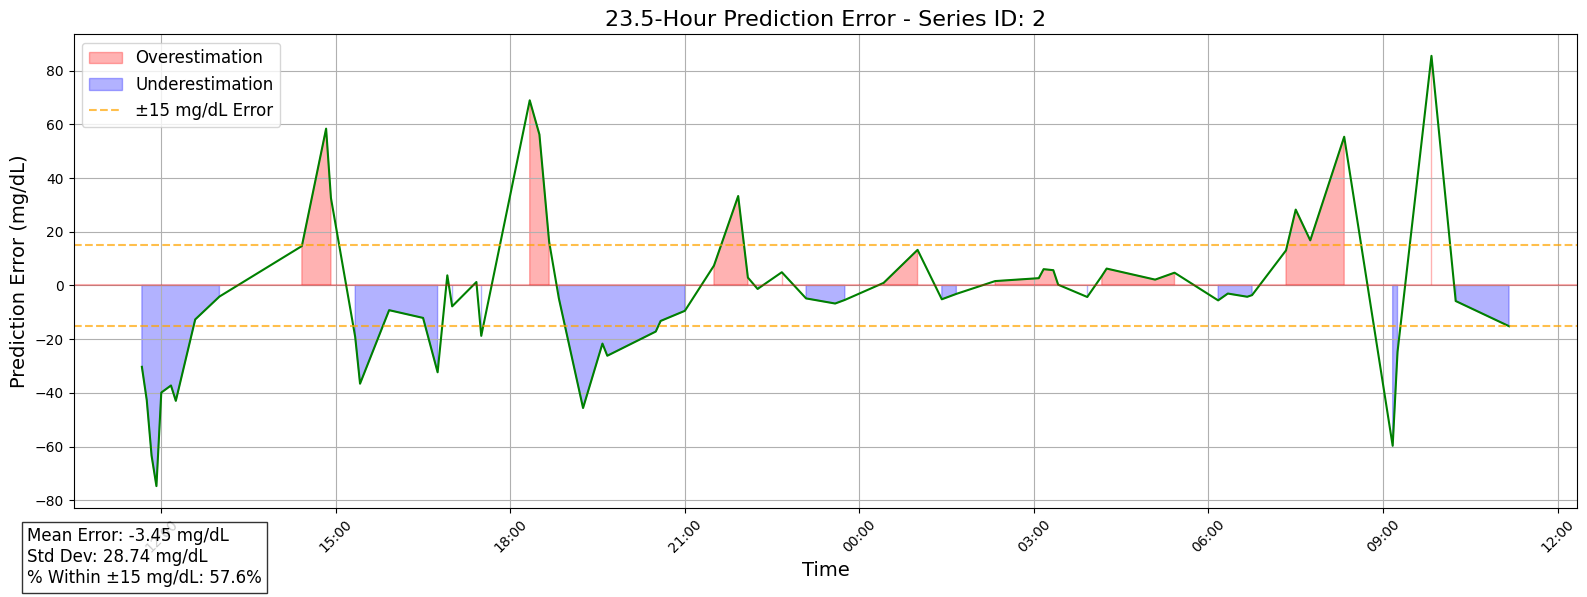

  Completed: 23.5 hours, 66 points, RMSE: 28.95
Processing series 5/5: 4


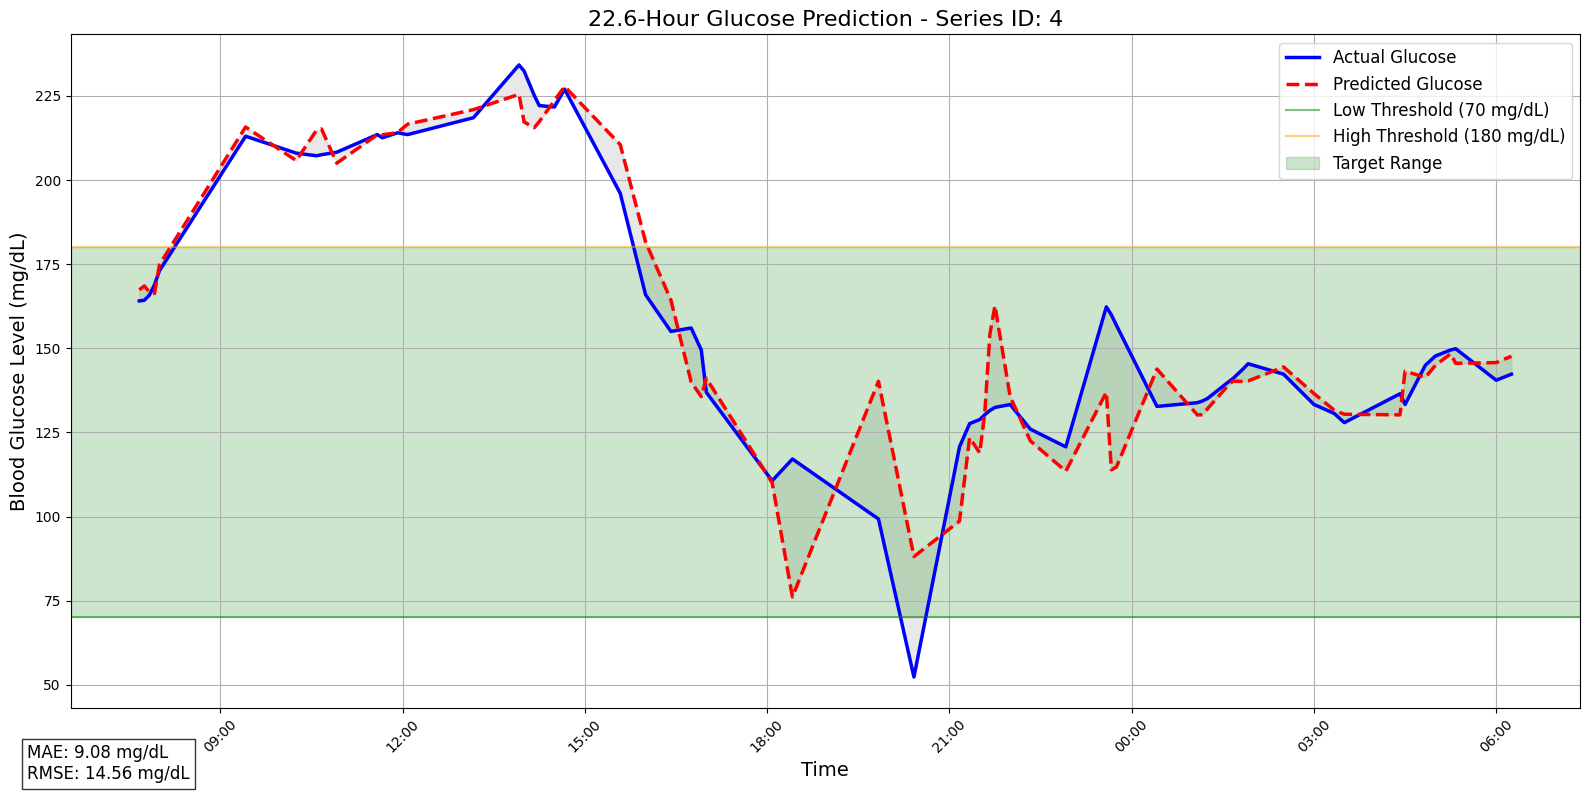

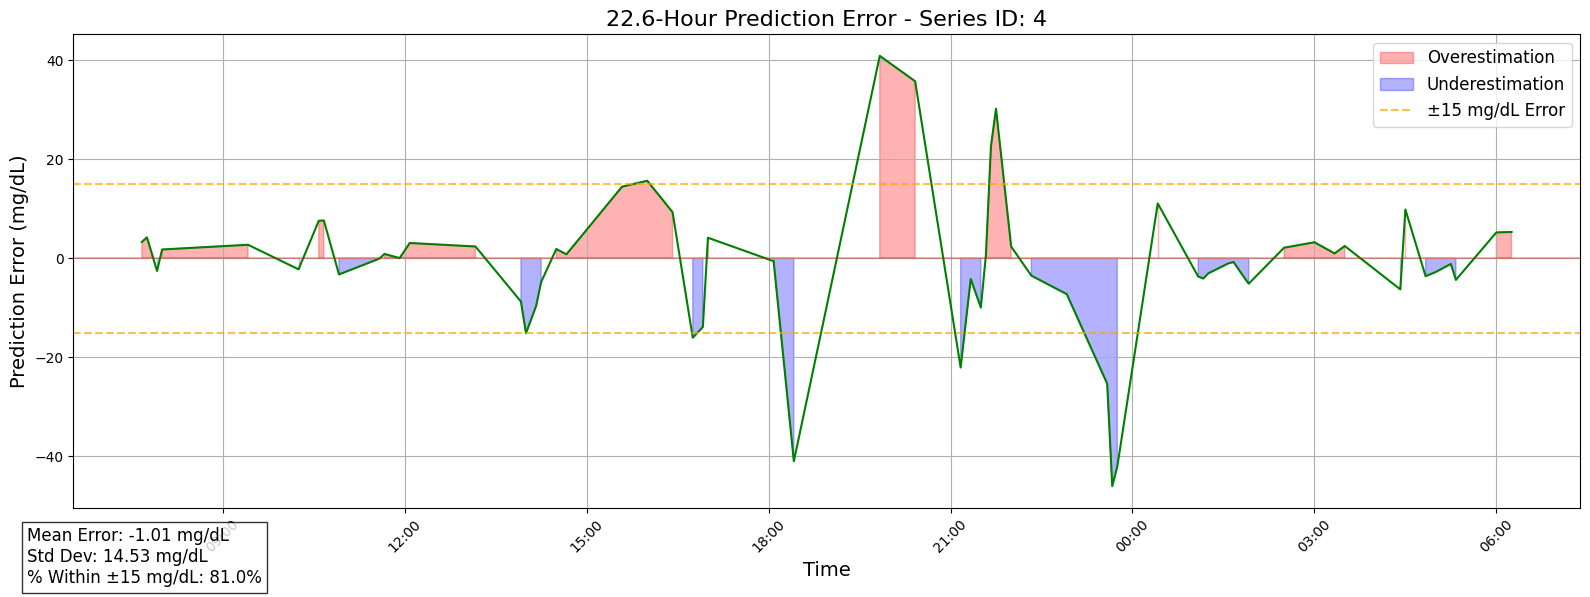

  Completed: 22.6 hours, 63 points, RMSE: 14.56

===== SUMMARY STATISTICS =====
Total series processed: 5
Average MAE across all series: 10.44 mg/dL
Average RMSE across all series: 16.16 mg/dL
Average accuracy within ±15 mg/dL: 79.86%
Average hours of data per series: 23.40
Summary statistics saved to 'series_performance_summary.csv'

----- Top 5 Best Performing Series (by RMSE) -----
   series_id       rmse        mae  percent_within_15  duration_hours
1          3   1.223170   0.493029         100.000000       23.916667
0          1  11.249966   8.053003          86.153846       23.750000
4          4  14.562456   9.077354          80.952381       22.583333
2          5  24.813461  14.564630          74.626866       23.250000
3          2  28.946826  20.031126          57.575758       23.500000

----- Top 5 Worst Performing Series (by RMSE) -----
   series_id       rmse        mae  percent_within_15  duration_hours
3          2  28.946826  20.031126          57.575758       23.500000

In [ ]:
#24 hour for each ID, showing plots
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import math
import sqlite3
import os
from datetime import timedelta

# Create output directory for images
os.makedirs('series_visualizations', exist_ok=True)

# Connect to the database and load data
conn = sqlite3.connect('cgm_light.db')
df = pd.read_sql("SELECT * FROM cgm_data", conn)
conn.close()

# Data preprocessing
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values(by=['series_id', 'datetime'], inplace=True)

# Remove duplicates
df = df.groupby(['series_id', 'datetime'], as_index=False).agg({'blood_glucose': 'mean'})

# Resample to 5-minute intervals and interpolate
resampled = []
for sid, group in df.groupby('series_id'):
    group = group.set_index('datetime').sort_index()

    # Resample to 5-minute intervals
    group_resampled = group.resample('5min').mean()

    # Interpolate missing values
    if group_resampled['blood_glucose'].notna().sum() >= 3:
        try:
            group_resampled['blood_glucose'] = group_resampled['blood_glucose'].interpolate(method='polynomial', order=2)
        except:
            group_resampled['blood_glucose'] = group_resampled['blood_glucose'].interpolate(method='linear')
    else:
        group_resampled['blood_glucose'] = group_resampled['blood_glucose'].interpolate(method='linear')

    # Fill remaining edge NaNs
    group_resampled['blood_glucose'] = group_resampled['blood_glucose'].bfill().ffill()

    # Add series_id back
    group_resampled['series_id'] = sid
    resampled.append(group_resampled)

df_resampled = pd.concat(resampled).reset_index()

# Feature engineering
df_resampled['hour'] = df_resampled['datetime'].dt.hour
df_resampled['dayofweek'] = df_resampled['datetime'].dt.dayofweek
df_resampled['glucose_lag_1'] = df_resampled.groupby('series_id')['blood_glucose'].shift(1)
df_resampled['glucose_lag_6'] = df_resampled.groupby('series_id')['blood_glucose'].shift(6)
df_resampled['glucose_target'] = df_resampled.groupby('series_id')['blood_glucose'].shift(-6)  # 30 minutes in the future
df_resampled = df_resampled.dropna()

# --- Define Features and Target ---
features = ['hour', 'dayofweek', 'glucose_lag_1', 'glucose_lag_6', 'series_id']
target = 'glucose_target'

# Create a copy of the dataframe to work with
df_ml = df_resampled.copy()

# Create features (X) and target (y)
X = df_ml[features]
y = df_ml[target]

# One-hot encode 'series_id'
X = pd.get_dummies(X, columns=['series_id'], drop_first=True)

# --- Train-Test Split ---
# Save the indices for later reference
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_indices = X_train.index
test_indices = X_test.index

# --- Hyperparameter Tuning with GridSearchCV ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

print("Training random forest with grid search...")
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# --- Evaluate Best Model ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Root Mean Squared Error after tuning: {rmse}")

# Create a new dataframe for test data with predictions
test_data = df_ml.loc[test_indices].copy()
test_data['predicted_glucose'] = y_pred

# Get list of unique series_ids in the test set
unique_series_ids = test_data['series_id'].unique()
print(f"Number of series_ids in test set: {len(unique_series_ids)}")

# Function to extract 24 hours of data from a series
def extract_24hr_data(series_data):
    series_data = series_data.sort_values('datetime')

    if len(series_data) < 12:  # At least 1 hour of data (12 5-minute readings)
        return None

    # Find the longest continuous period
    max_continuous_period = timedelta(0)
    start_idx = 0
    best_start_idx = 0

    for i in range(1, len(series_data)):
        time_diff = series_data.iloc[i]['datetime'] - series_data.iloc[i-1]['datetime']

        # If there's a gap larger than 5 minutes (allowing for small rounding errors)
        if time_diff > timedelta(minutes=7):
            period_duration = series_data.iloc[i-1]['datetime'] - series_data.iloc[start_idx]['datetime']
            if period_duration > max_continuous_period:
                max_continuous_period = period_duration
                best_start_idx = start_idx
            start_idx = i

    # Check the last segment
    period_duration = series_data.iloc[-1]['datetime'] - series_data.iloc[start_idx]['datetime']
    if period_duration > max_continuous_period:
        max_continuous_period = period_duration
        best_start_idx = start_idx

    # If we have found a period of at least 24 hours
    if max_continuous_period >= timedelta(hours=24):
        continuous_data = series_data.iloc[best_start_idx:].copy()
        start_time = continuous_data.iloc[0]['datetime']
        end_time = start_time + timedelta(hours=24)

        # Extract exactly 24 hours of data
        exact_24hr_data = continuous_data[
            (continuous_data['datetime'] >= start_time) &
            (continuous_data['datetime'] < end_time)
        ]

        return exact_24hr_data

    # If we don't have 24 hours, return the longest continuous segment we found
    continuous_data = series_data.iloc[best_start_idx:].copy()

    # If we have more than 24 hours, limit to the first 24 hours
    if (continuous_data.iloc[-1]['datetime'] - continuous_data.iloc[0]['datetime']) > timedelta(hours=24):
        start_time = continuous_data.iloc[0]['datetime']
        end_time = start_time + timedelta(hours=24)
        continuous_data = continuous_data[
            (continuous_data['datetime'] >= start_time) &
            (continuous_data['datetime'] < end_time)
        ]

    return continuous_data

# Function to visualize one series
def visualize_series(series_id, series_data, output_dir='series_visualizations'):
    # Ensure the series data is sorted by time
    series_data = series_data.sort_values('datetime')

    duration_hours = (series_data['datetime'].max() - series_data['datetime'].min()).total_seconds() / 3600

    # Visualize the results - 24-hour period (or less if complete 24 hours not available)
    plt.figure(figsize=(16, 8))

    # Plot actual vs predicted glucose values
    plt.plot(series_data['datetime'], series_data['glucose_target'], 'b-', linewidth=2.5, label='Actual Glucose')
    plt.plot(series_data['datetime'], series_data['predicted_glucose'], 'r--', linewidth=2.5, label='Predicted Glucose')

    # Add shading between the lines to highlight differences
    plt.fill_between(series_data['datetime'],
                     series_data['glucose_target'],
                     series_data['predicted_glucose'],
                     color='lightgray', alpha=0.5)

    # Add reference lines for normal glucose range (70-180 mg/dL)
    plt.axhline(y=70, color='g', linestyle='-', alpha=0.5, label='Low Threshold (70 mg/dL)')
    plt.axhline(y=180, color='orange', linestyle='-', alpha=0.5, label='High Threshold (180 mg/dL)')
    plt.axhspan(70, 180, alpha=0.2, color='green', label='Target Range')

    # Add a title and labels
    plt.title(f'{duration_hours:.1f}-Hour Glucose Prediction - Series ID: {series_id}', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Blood Glucose Level (mg/dL)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Format x-axis for better readability (show hours)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    plt.tight_layout()

    # Calculate error metrics for this series
    series_mae = np.mean(np.abs(series_data['predicted_glucose'] - series_data['glucose_target']))
    series_rmse = np.sqrt(np.mean((series_data['predicted_glucose'] - series_data['glucose_target'])**2))

    # Add error metrics to the plot
    plt.figtext(0.02, 0.02, f"MAE: {series_mae:.2f} mg/dL\nRMSE: {series_rmse:.2f} mg/dL",
               fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.savefig(f'{output_dir}/series_{series_id}_prediction.png', dpi=300)
    plt.show()  # Show the plot
    plt.close()  # Close to free memory

    # Create a second plot showing the error over time
    plt.figure(figsize=(16, 6))
    error = series_data['predicted_glucose'] - series_data['glucose_target']
    plt.plot(series_data['datetime'], error, 'g-', linewidth=1.5)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.fill_between(series_data['datetime'], error, 0, where=(error > 0), color='red', alpha=0.3, label='Overestimation')
    plt.fill_between(series_data['datetime'], error, 0, where=(error < 0), color='blue', alpha=0.3, label='Underestimation')

    # Add horizontal lines showing error thresholds
    plt.axhline(y=15, color='orange', linestyle='--', alpha=0.7, label='±15 mg/dL Error')
    plt.axhline(y=-15, color='orange', linestyle='--', alpha=0.7)

    plt.title(f'{duration_hours:.1f}-Hour Prediction Error - Series ID: {series_id}', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Prediction Error (mg/dL)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Format x-axis
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    plt.tight_layout()

    # Calculate error statistics
    mean_error = np.mean(error)
    std_error = np.std(error)
    percent_within_15 = 100 * np.mean(np.abs(error) <= 15)

    # Add error statistics to the plot
    plt.figtext(0.02, 0.02,
               f"Mean Error: {mean_error:.2f} mg/dL\nStd Dev: {std_error:.2f} mg/dL\n% Within ±15 mg/dL: {percent_within_15:.1f}%",
               fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.savefig(f'{output_dir}/series_{series_id}_error.png', dpi=300)
    plt.show()  # Show the plot
    plt.close()  # Close to free memory

    # Return the performance metrics for summary
    return {
        'series_id': series_id,
        'duration_hours': duration_hours,
        'data_points': len(series_data),
        'mae': series_mae,
        'rmse': series_rmse,
        'mean_error': mean_error,
        'std_error': std_error,
        'percent_within_15': percent_within_15
    }

# Create a list to store performance metrics for all series
all_metrics = []

# Limit number of series to process to avoid too many plots
max_series_to_process = 5  # Adjust this value as needed
series_to_process = unique_series_ids[:max_series_to_process]

# Process each series
for i, series_id in enumerate(series_to_process):
    print(f"Processing series {i+1}/{len(series_to_process)}: {series_id}")

    # Extract data for this series
    series_data = test_data[test_data['series_id'] == series_id].copy()

    # Get the best 24-hour segment (or less if not available)
    series_24hr_data = extract_24hr_data(series_data)

    if series_24hr_data is None or len(series_24hr_data) < 12:  # Skip if less than 1 hour of data
        print(f"  Skipping series {series_id}: insufficient data")
        continue

    # Visualize and get metrics
    metrics = visualize_series(series_id, series_24hr_data)
    all_metrics.append(metrics)

    print(f"  Completed: {metrics['duration_hours']:.1f} hours, {metrics['data_points']} points, RMSE: {metrics['rmse']:.2f}")

# Create a summary DataFrame
summary_df = pd.DataFrame(all_metrics)

# Calculate overall metrics
print("\n===== SUMMARY STATISTICS =====")
print(f"Total series processed: {len(summary_df)}")
print(f"Average MAE across all series: {summary_df['mae'].mean():.2f} mg/dL")
print(f"Average RMSE across all series: {summary_df['rmse'].mean():.2f} mg/dL")
print(f"Average accuracy within ±15 mg/dL: {summary_df['percent_within_15'].mean():.2f}%")
print(f"Average hours of data per series: {summary_df['duration_hours'].mean():.2f}")

# Save the summary stats to CSV
summary_df.to_csv('series_performance_summary.csv', index=False)
print("Summary statistics saved to 'series_performance_summary.csv'")

# Sort and display the best and worst performing series
best_series = summary_df.sort_values('rmse').head(5)
worst_series = summary_df.sort_values('rmse', ascending=False).head(5)

print("\n----- Top 5 Best Performing Series (by RMSE) -----")
print(best_series[['series_id', 'rmse', 'mae', 'percent_within_15', 'duration_hours']])

print("\n----- Top 5 Worst Performing Series (by RMSE) -----")
print(worst_series[['series_id', 'rmse', 'mae', 'percent_within_15', 'duration_hours']])